## B cells versus T cells
The data used in this notebook is lymphocyte data for one patient's B cells and T cells. We use this data to show the proteome variation between the cell types. Here, we note presence/absense changes and quantify fold changes using a T test.


First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
data_raw = load_data.load_FragPipe(version="June_selected_FP")
#data_raw=load_data.load_max_quant()

data_raw

,Subject1_FACS145_B_022920_C10,Subject1_FACS145_B_022920_C11,Subject1_FACS145_B_022920_C12,Subject1_FACS145_B_022920_C13,Subject1_FACS145_B_022920_C9,Subject1_FACS145_T_022920_D10,Subject1_FACS145_T_022920_D12,Subject1_FACS145_T_022920_D13,Subject1_FACS145_T_022920_D9,Subject1_FACS145_T_062920_D11
Protein ID,,,,,,,,,,
A0A0B4J2D5,819194.25,1203040.90,439446.10,1906699.40,1330848.20,283948.94,78067.72,0.00,123710.484,181092.27
A0AVT1,501930.78,718435.75,824289.10,495488.97,0.00,0.00,0.00,0.00,401786.880,559705.25
A6NHR9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.00
A8MWD9,738986.20,971444.40,789952.70,960253.10,319829.47,0.00,0.00,0.00,344603.060,394223.78
B5ME19,785554.06,1040235.90,632014.44,709235.70,362616.84,403412.84,674793.25,974256.94,720808.750,736337.70
...,...,...,...,...,...,...,...,...,...,...
Q8WWY7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.00
Q92597,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000,0.00
Q92953,7166249.00,0.00,6292137.50,0.00,9075473.00,0.00,0.00,0.00,5203961.000,1345615.80


These are some methods that assist with the data analysis, such as checking if a value was measured or not and if the protein was measured in each type.

In [2]:
import data_utils

Before any analysis, we log normalize and median normalize across runs.

In [3]:
data_log2_normalized = data_utils.normalize(data_raw)

Our next steps will require separating the runs by cell type, to compare B cells to T cells. As you see above, the pattern for naming the columns is "Intensity ", B or T indicating cell type, and the replicate number. Here we define the list of cell types that the functions should look for based on the naming pattern.

In [4]:
cell_types=['B_', 'T_']

Here we record which proteins are only identified in one cell type. We'll set these aside for now, in the <code>data_in_one_type</code> dataframe. Note that <code>min_reps</code> is the minimum number of replicates required to list a protein as present in one type. This can be changed, i.e., <code>min_reps=5</code> to determine the proteins identified in all 5 replicates of a single type; do not set it to a number greater than the replicates run or no proteins will be returned.

In [5]:
present_only_in = data_log2_normalized.apply(data_utils.check_presence_absence, axis=1, 
                                             min_reps=3, cell_types=cell_types).dropna()
print("Proteins identified only in:")
print(present_only_in.value_counts())
data_in_one_type =data_log2_normalized.loc[present_only_in.index]
data_in_one_type['Type'] = present_only_in

Proteins identified only in:
B_    69
T_    56
dtype: int64


Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [6]:
indecies = data_log2_normalized.apply(data_utils.check_three_of_each_type, axis=1, cell_types=cell_types)
data = data_log2_normalized[indecies]

In [7]:
print ("Total groups identified:")
print(data_raw.shape[0])

print ("Proteins identified in at least 3 of each cell type:\t")
print (data.shape[0])

Total groups identified:
1564
Proteins identified in at least 3 of each cell type:	
904


Now we calulate p values using a ttest. 

In [8]:
#Call ttest function
tstats = data.apply(data_utils.ttest_wrapper, axis=1, cell_types=cell_types)

D:\Program_Files\Anaconda\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Here we calculate fold change.

In [9]:
tstats['log2(B)-log2(T)'] = data.apply(data_utils.get_fold_changes, axis=1, cell_types=cell_types)

Fold change and p values allow us to create a volcano plot.

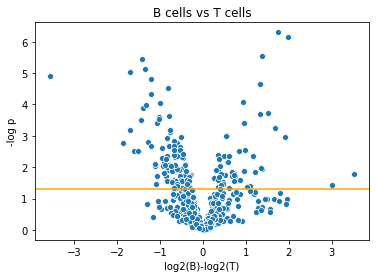

In [10]:
#graph volcano
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import log10
tstats['-log p'] = -log10(tstats['pvalue'])

figure = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats)
figure.set_title("B cells vs T cells")
#plt.axvline(1, color ='orange')
#plt.axvline(-1, color ='orange')
plt.axhline(-log10(.05), color ='orange')
plt.show()

Next we will identify the altered proteins.

In [11]:
altered = tstats.apply(data_utils.is_altered, axis=1, change_factor=False).dropna()

These are significantly altered (p<0.01) without restricting by the magnitude of change:

In [12]:
altered.value_counts()

T cells    56
B cells    23
dtype: int64

In [13]:
print("Here are counts for other p and change cutoffs:")
print("P<0.05, >150% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.05,change_factor=1.5).value_counts()) #50% increase from either
print("\nP<0.05, >200% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.05,change_factor=2).value_counts()) #Double
print("\nP<0.05, >500% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.05,change_factor=5).value_counts()) #5 times larger

print("\nP<0.01, >150% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.01,change_factor=1.5).value_counts()) #50% increase from either
print("\nP<0.01, >200% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.01,change_factor=2).value_counts()) #Double
print("\nP<0.01, >500% of the other type")
print(tstats.apply(data_utils.is_altered, axis=1, pvalue=.01,change_factor=5).value_counts()) #5 times larger

Here are counts for other p and change cutoffs:
P<0.05, >150% of the other type
T cells    63
B cells    30
dtype: int64

P<0.05, >200% of the other type
T cells    23
B cells    16
dtype: int64

P<0.05, >500% of the other type
B cells    2
T cells    1
dtype: int64

P<0.01, >150% of the other type
T cells    47
B cells    14
dtype: int64

P<0.01, >200% of the other type
T cells    21
B cells     9
dtype: int64

P<0.01, >500% of the other type
T cells    1
dtype: int64


### Differentially expressed proteins

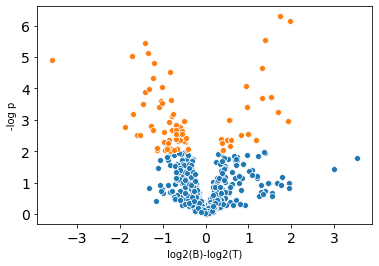

In [14]:
figure = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats)
figure2 = sns.scatterplot(x='log2(B)-log2(T)',y='-log p',data=tstats.loc[altered.index])
plt.rc('axes',labelsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title("B cells vs T cells", fontsize=20)

plt.savefig("data/figures_selected_FP/BvsT.png", dpi=300)

This shows the differentially expressed proteins. Recall that this dataset is restricted to those expressed in at least three of each cell type.

The next step is to identify those proteins by name. Here we get the protein names from the fasta file, which remain the same regardless of which software the data was quantified using.

In [15]:
protein_names = load_data.load_fasta()

In [16]:
import pandas as pd
protein_names_by_group={}
for ID in data_raw.index:
    if ';' in ID:
        ids = ID.split(';')
        names=''
        for i in ids:
            if i in protein_names.index:
                names=names + protein_names[i] + ';'
        names = names[:-1]
        protein_names_by_group[ID] = names
    else:
        if ID in protein_names.index:
            protein_names_by_group[ID]=protein_names[ID]
protein_names_by_group = pd.Series(list(protein_names_by_group.values()), index=protein_names_by_group.keys())

Here we add the names to the <code>tstats</code> dataframe, which contains the fold changes for each protein. Then we can list the proteins that are altered. Optionally, use <code> head()</code> to display the first few or <code>to_csv</code> to write out to a file. We now split up the proteins heightened in B cells from those heightened in T cells.

In [17]:
tstats['Name']=protein_names_by_group
tstats['GeneID'] = tstats.Name.apply(lambda n: str(n).split('_HUMAN')[0])

altered_proteins = tstats.loc[altered.index].sort_values('log2(B)-log2(T)',
                        ascending=False)[['pvalue','log2(B)-log2(T)','Name','GeneID']]
higher_in_B_cells = altered_proteins.loc[altered_proteins['log2(B)-log2(T)'] >0]
higher_in_T_cells = altered_proteins.loc[altered_proteins['log2(B)-log2(T)'] <0]

#To write out to a file, use:
#altered_proteins.to_csv('data/filename.tsv', sep='\t')

Next we do the same for those only identified in one cell type.

In [18]:
data_in_one_type['Name'] = protein_names_by_group
data_in_one_type['GeneID']=data_in_one_type.Name.apply(lambda n: str(n).split('_HUMAN')[0])

B_cell_only_geneset = data_in_one_type[(data_in_one_type.Type=='B_')]
T_cell_only_geneset= data_in_one_type[(data_in_one_type.Type=='T_')]

### Proteins Higher in B Cells:

In [19]:
higher_in_B_cells

,pvalue,log2(B)-log2(T),Name,GeneID
Protein ID,,,,
P09960,7.198480e-07,1.972804,LKHA4_HUMAN Leukotriene A-4 hydrolase,LKHA4
P01834,1.092879e-03,1.913174,IGKC_HUMAN Immunoglobulin kappa constant,IGKC
P29350,5.002525e-07,1.744085,PTN6_HUMAN Tyrosine-protein phosphatase non-re...,PTN6
P0DOY2,5.558317e-04,1.684692,IGLC2_HUMAN Immunoglobulin lambda constant 2,IGLC2
P09525,1.857150e-04,1.525379,ANXA4_HUMAN Annexin A4,ANXA4
P09874,2.778706e-06,1.377227,PARP1_HUMAN Poly [ADP-ribose] polymerase 1,PARP1
P27707,2.038183e-04,1.325106,DCK_HUMAN Deoxycytidine kinase,DCK
Q96KP4,2.237074e-05,1.321275,CNDP2_HUMAN Cytosolic non-specific dipeptidase,CNDP2
P58546,4.286378e-03,1.164319,MTPN_HUMAN Myotrophin,MTPN


### Proteins Only in B Cells:

In [20]:
B_cell_only_geneset[['Name', 'GeneID']]

,Name,GeneID
Protein ID,,
O15400,TX7_HUMAN Syntaxin-7,TX7
O60262,GBG7_HUMAN Guanine nucleotide-binding protein ...,GBG7
O75223,GGCT_HUMAN Gamma-glutamylcyclotransferase,GGCT
O75608,LYPA1_HUMAN Acyl-protein thioesterase 1,LYPA1
O75874,IDHC_HUMAN Isocitrate dehydrogenase [NADP] cyt...,IDHC
...,...,...
P01880,IGHD_HUMAN Immunoglobulin heavy constant delta,IGHD
Q8TDP1,RNH2C_HUMAN Ribonuclease H2 subunit C,RNH2C
Q9UBR2,CATZ_HUMAN Cathepsin Z,CATZ


### Proteins higher or only in B cells by GeneID
<code>B_cell_set</code> is defined here as both the above lists of names, those higher or only in B cells.

In [21]:
B_cell_set = list(higher_in_B_cells.GeneID)+list(B_cell_only_geneset.GeneID)

### Proteins Higher in T Cells:

In [22]:
higher_in_T_cells.sort_values('log2(B)-log2(T)',ascending=True)

,pvalue,log2(B)-log2(T),Name,GeneID
Protein ID,,,,
P26447,0.000013,-3.571146,10A4_HUMAN Protein S100-A4,10A4
Q15149,0.001746,-1.865700,PLEC_HUMAN Plectin,PLEC
P12814,0.000009,-1.710082,ACTN1_HUMAN Alpha-actinin-1,ACTN1
P31949,0.000654,-1.699055,10AB_HUMAN Protein S100-A11,10AB
O15533,0.003014,-1.597947,TPSN_HUMAN Tapasin,TPSN
Q9Y2Q3,0.003051,-1.525526,GSTK1_HUMAN Glutathione S-transferase kappa 1,GSTK1
Q99733,0.000316,-1.454706,NP1L4_HUMAN Nucleosome assembly protein 1-like 4,NP1L4
P08670,0.000004,-1.420240,VIME_HUMAN Vimentin,VIME
P07195,0.000127,-1.408794,LDHB_HUMAN L-lactate dehydrogenase B chain,LDHB


### Proteins Only in T Cells:

In [23]:
T_cell_only_geneset[['Name', 'GeneID']]

,Name,GeneID
Protein ID,,
O00584,RNT2_HUMAN Ribonuclease T2,RNT2
O15117,FYB1_HUMAN FYN-binding protein 1,FYB1
O43665,RGS10_HUMAN Regulator of G-protein signaling 10,RGS10
O60496,DOK2_HUMAN Docking protein 2,DOK2
O60711,LPXN_HUMAN Leupaxin,LPXN
O95571,"ETHE1_HUMAN Persulfide dioxygenase ETHE1, mito...",ETHE1
P06127,CD5_HUMAN T-cell surface glycoprotein CD5,CD5
P06729,CD2_HUMAN T-cell surface antigen CD2,CD2
P07305,H10_HUMAN Histone H1.0,H10


### Proteins higher or only in T cells by GeneID
<code>T_cell_set</code> is defined here as both the above lists of names, those higher or only in T cells.

In [24]:
T_cell_set = list(higher_in_T_cells.GeneID)+list(T_cell_only_geneset.GeneID)